In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev
from pyproj import Transformer

start_date = np.datetime64('2024-09-25 00:00:00')
end_date = np.datetime64('2024-09-28 00:00:00')

# read COAWST model results
# John's Helene hindcast
url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'

dsm = xr.open_dataset(url)
latm = dsm.lat_rho.values
lonm = dsm.lon_rho.values
time_all = dsm.ocean_time.values
idxms = int( np.where(time_all >= start_date)[0][0] )
idxme = int( np.where(time_all <= end_date)[0][-1] )
timem = time_all[idxms:idxme]
mask_rho = dsm.mask_rho.values
# TODO - change the time of the wet-dry mask
#wd_mask_rho = dsm.wetdry_mask_rho[19,:,:].values
wd_mask_rho = dsm.mask_rho[:,:].values

# Find closest model grid point
# Calculate the difference between the model grid points and the buoy locations; find model indices to closest points
model_shape = np.shape( lonm )
print('model shape: ',model_shape)
print('nlat, nlon: ',np.shape(mask_rho))


model shape:  (512, 833)
nlat, nlon:  (512, 833)


In [2]:
# Extract the depth, latitude, longitude, and mask (0=land, 1=water)
h = dsm['h'].values
lat = dsm['lat_rho'].values
lon = dsm['lon_rho'].values
mask = wd_mask_rho

In [3]:
# Model grid: lon_grid, lat_grid (2D arrays)
# convert to UTM
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32617", always_xy=True)
xm, ym = transformer.transform(lon, lat)
# find differences in model grid spacing
dxm = np.diff(xm)
dym = np.diff(ym)
print('Model spacing: xmean {:.1f}, xmin {:.1f} xmax {:.1f}'.format( np.mean(dxm), np.min(dxm), np.max(dxm) ) )
print('Model spacing: ymean {:.1f}, ymin {:.1f} ymax {:.1f}'.format( np.mean(dym), np.min(dym), np.max(dym) ) )

Model spacing: xmean 1491.1, xmin 1351.1 xmax 1601.2
Model spacing: ymean 727.2, ymin 612.1 ymax 835.3


Text(0, 0.5, 'Latitude')

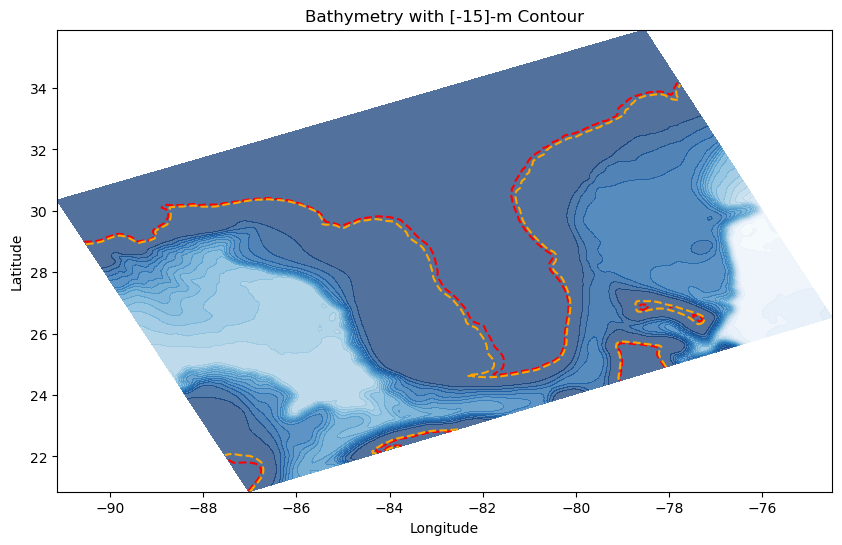

In [4]:
# Plot the depth and  contour
contour_level = [-15 ]
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, -h, levels=20, cmap='Blues', alpha=0.7)
_ = plt.contour(lon, lat, -h, levels=[-10], colors='red')
contour = plt.contour(lon, lat, -h, levels=[-15], colors='orange')
#plt.colorbar(label="Depth (m)")
plt.title(f"Bathymetry with {contour_level}-m Contour")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

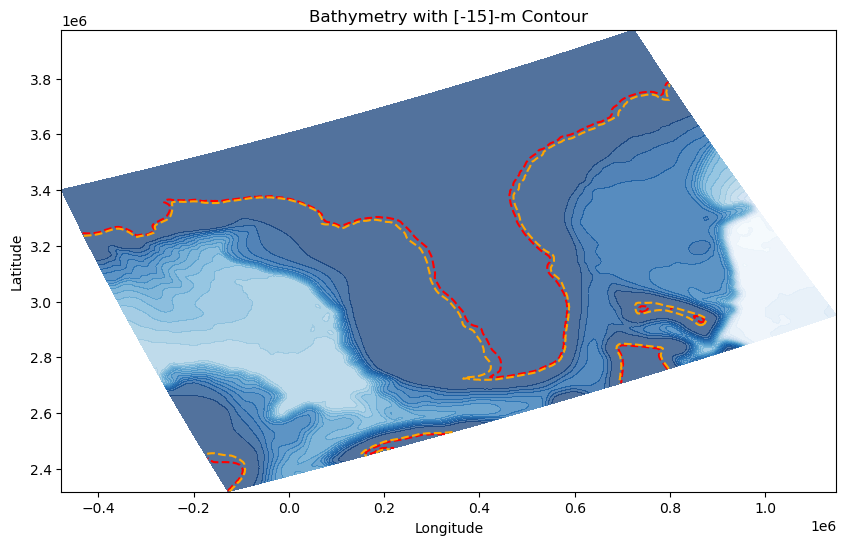

In [5]:
# Plot the depth and  contour
contour_level = [-15 ]
plt.figure(figsize=(10, 6))
plt.contourf(xm, ym, -h, levels=20, cmap='Blues', alpha=0.7)
_ = plt.contour(xm, ym, -h, levels=[-10], colors='red')
contour = plt.contour(xm, ym, -h, levels=[-15], colors='orange')
#plt.colorbar(label="Depth (m)")
plt.title(f"Bathymetry with {contour_level}-m Contour")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Contour 0: 2686 points
contour15 point spacing: mean 1559.2, min 2.2 max 2705.6


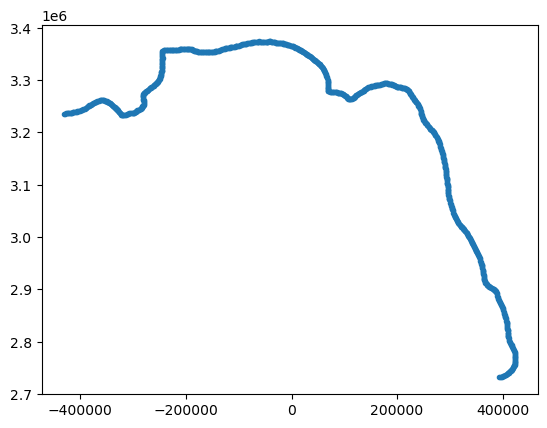

In [6]:
# Extract the vertices from the contour
contour_paths = contour.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# After some fiddling, this looks like the region we need
contour15 = vertices[522:1450,:]

# Compute distances along the contour
dxyc = np.diff(contour15, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour15 point spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

plt.plot(contour15[:,0], contour15[:,1],'.')

In [7]:
# Apply Gaussian smoothing to the coordinates
sigma = 20  # Smoothing parameter (higher = smoother)
contour15s = np.column_stack((
    gaussian_filter1d(contour15[:, 0], sigma=sigma),  # Smooth longitude
    gaussian_filter1d(contour15[:, 1], sigma=sigma)   # Smooth latitude
))

# interpolate with splines to semi-regular spacing
x, y = contour15s[:, 0], contour15s[:, 1]

# Fit parametric spline (no smoothing)
tck, u = splprep([contour15s[:,0], contour15s[:,1]], s=0)

# Create new u values for target spacing
n_interp = int(np.ceil(u[-1] / (5 / np.mean(np.linalg.norm(np.diff(contour15, axis=0), axis=1)))))
u_new = np.linspace(0, 1, n_interp)

# Evaluate spline
x_new, y_new = splev(u_new, tck)
contour15sp = np.column_stack((x_new, y_new))

# Compute distances along the contour
dxyc = np.diff(contour15sp, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour15sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

contour15sp spacing: mean 4177.9, min 4175.7 max 4178.2


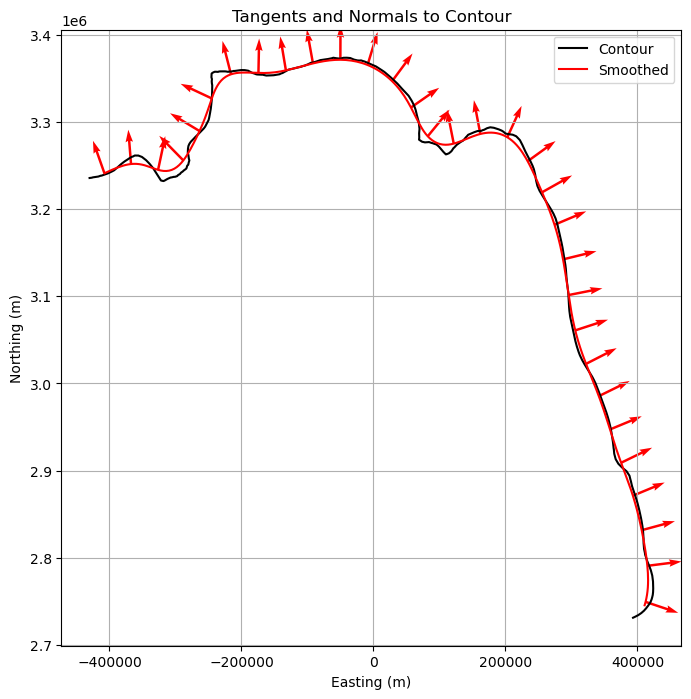

In [8]:
# Compute tangents
tangents = np.gradient(contour15sp, axis=0)  # Forward/backward difference for each point

# Normalize tangents
tangents_norm = np.linalg.norm(tangents, axis=1, keepdims=True)
tangents_unit = tangents / tangents_norm

# Compute normals
normals = np.zeros_like(tangents)
normals[:, 0] = tangents_unit[:, 1]  # ty -> nx (swap and change sign)
normals[:, 1] = -tangents_unit[:, 0] # -tx -> ny

# Visualize tangents and normals
plt.figure(figsize=(8, 8))
plt.plot(contour15[:, 0], contour15[:, 1], 'k-', label='Contour')
plt.plot(contour15sp[:, 0], contour15sp[:, 1], 'r-', label='Smoothed')

# Plot the normals, flip the normals by changing signs, plot every skip
skip = 10
plt.quiver(
    contour15sp[::skip, 0], contour15sp[::skip, 1], -normals[::skip, 0], -normals[::skip, 1],
    color = 'r', width = .004)
#    color='b', angles='xy', scale_units='xy', scale=2, width=.002, label='Normals')
plt.ylabel('Northing (m)')
plt.xlabel('Easting (m)')
plt.legend()
plt.title('Tangents and Normals to Contour')
plt.grid()
plt.show()

In [9]:
# Convert contour points back to lat/lon
transformerT = Transformer.from_crs("EPSG:32617", "EPSG:4326", always_xy=True)
contour15sp_lon, contour15sp_lat = transformerT.transform(contour15sp[:,0], contour15sp[:,1] )

# Create DataFrame
df = pd.DataFrame({
    "contour15s_lon": contour15sp_lon,
    "contour15s_lat": contour15sp_lat,
    "contour15s_x":contour15sp[:,0],
    "contour15s_y":contour15sp[:,1],
    "normals_x": -normals[:,0],
    "normals_y": -normals[:,1]
})

# Save to CSV
df.to_csv("contour15sp.csv", index=False)

print("CSV file saved as contour15sp.csv")

CSV file saved as contour15sp.csv
